In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [2]:
def rastring_func(x):
    # f(x) = A*n + sum(x_i^2 - A*cos(2*pi*x_i))
    return 10*len(x) + np.sum(x**2 - 10*np.cos(2*np.pi*x), axis=1)

def simple_func(x):
    # f(x, y, z) = x^2 + y^2 + 2z^2
    return x[:, 0]**2 + x[:, 1]**2 + 2*x[:, 2]**2

In [184]:
class genetic_algorythm:
	def __init__(self, population_size, genotyp_size, bounds):
		self.population_size = population_size
		self.genotyp_size = genotyp_size
		self.initialize_population(population_size, genotyp_size, bounds)
		
	def initialize_population(self, population_size, genotype_size, bounds):
		self.population = np.random.uniform(bounds[0], bounds[1], (population_size, genotype_size))
	
	def check_stop_criterion(self):
		self.iteration += 1
		self.mean_resoults.append(np.mean(self.objective_function(self.population)))
		best = np.min(self.objective_function(self.population))
		if best >= self.best_resoult: 
			self.no_imporvement_iteration += 1
		else: 
			self.no_imporvement_iteration = 0
			self.best_resoult = best
			self.best_speciment = self.population[np.argmin(self.objective_function(self.population))]
		self.best_resoults.append(self.best_resoult)

		match self.stop_criterion:
			case 'iterations':
				if self.iteration > self.stop_value: return 1
				else: return 0
			case 'imporvement':
				if self.no_imporvement_iteration > self.stop_value: return 1
				else: return 0
			case 'mean_resoult':
				if self.mean_resoults[-1] < self.stop_value: return 1
				else: return 0
			case 'time':
				elapsed_time = time.time() - self.start_time
				if elapsed_time > self.stop_value: return 1
				else: return 0
	
	def onepoint_crossbreed(self):
		parents1 = self.population[np.random.permutation(len(self.population))]
		parents2 = self.population[np.random.permutation(len(self.population))]
		point = np.random.randint(1, self.genotyp_size)
		self.population = np.concatenate([parents1[:, :point], parents2[:, point:]], axis=1)

	def gauss_mutation(self):
		mutation_choice = np.random.choice(self.population_size, size=int(self.mutation_prob*self.population_size))
		self.population[mutation_choice] += np.random.normal(loc=0, scale=self.mutation_strength, size=(len(mutation_choice), self.genotyp_size))

	def selection(self):
		if self.elite_ratio != None:
			elite_population, rest_population = self.elite_selection(self.elite_ratio)
			match self.selection_type:
				case 'roulette':
					self.population = np.concatenate([elite_population, self.roulette_selection(rest_population)])
				case 'exponential':
					self.population = np.concatenate([elite_population, self.exponential_selection(rest_population)])
		else:
			match self.selection_type:
				case 'roulette':
					self.population = self.roulette_selection(self.population)
				case 'exponential':
					self.population = self.exponential_selection(self.population)

	def elite_selection(self, elite_ratio):
		results = self.objective_function(self.population)
		fitness = np.argsort(results)
		self.population = self.population[fitness]
		elite_size = int(self.population_size * elite_ratio)
		return self.population[:elite_size], self.population[elite_size:]

	def roulette_selection(self, population, check=False):
		# probability(result) = -result + min(result)
		population_size = len(population)
		results = -self.objective_function(population)
		fitness = results - np.min(results)
		prob = fitness / np.sum(fitness)

		ranks = np.argsort(-fitness)
		population = population[ranks]
		prob = prob[ranks]
		selection = np.random.choice(population_size, size=population_size, p=prob)

		if check:
			fig, ax1 = plt.subplots(figsize=(10, 5))
			ax2 = ax1.twinx()

			sns.lineplot(x=ranks, y=prob[ranks], ax=ax1, color='blue', label='probability')
			ax1.set_ylabel("Probability", color='blue')
			ax1.tick_params(axis='y', labelcolor='blue')

			ax2.bar(np.arange(population_size), np.bincount(selection, minlength=population_size), alpha=0.4, color='orange', label='selection count')
			ax2.set_ylabel("Selection Count", color='orange')
			ax2.tick_params(axis='y', labelcolor='orange')

			ax1.set_xlabel("Ranks")
			plt.title("roulette_selection:Probabilities vs. Selection Frequencies")

			plt.show()

		return population[selection]

	def exponential_selection(self, population, check=False):
		# probabilty(rank) = exp(-lambda*rank)
		# probabilty(cutoff) = grace
		# lambda = - ln(cutoff)/grace
		population_size = len(population)
		cutoff = 0.5
		grace = 0.2
		prob_lambda = -np.log(grace)/(cutoff*population_size)

		results = self.objective_function(population)
		fitness = np.argsort(results)
		population = population[fitness]
		ranks = np.arange(population_size)
		prob = np.exp(-prob_lambda*ranks)
		prob /= np.sum(prob)

		selection = np.random.choice(population_size, size=population_size, p=prob)
		
		if check:
			fig, ax1 = plt.subplots(figsize=(10, 5))
			ax2 = ax1.twinx()

			sns.lineplot(x=ranks, y=prob, ax=ax1, color='blue', label='probability')
			ax1.set_ylabel("Probability", color='blue')
			ax1.tick_params(axis='y', labelcolor='blue')

			ax2.bar(ranks, np.bincount(selection, minlength=self.population_size), alpha=0.4, color='orange', label='selection count')
			ax2.set_ylabel("Selection Count", color='orange')
			ax2.tick_params(axis='y', labelcolor='orange')

			ax1.set_xlabel("Ranks")
			plt.title("exponential_selection:Probabilities vs. Selection Frequencies")

			plt.show()

		return population[selection]

	def learn(self, objective_function, stop_criterion, stop_value, mutation_prob, mutation_strength, 
		   selection_type, elite_ratio):
		# stop check
		self.stop_criterion = stop_criterion
		self.stop_value = stop_value
		self.start_time = time.time()
		self.iteration = 1
		self.no_imporvement_iteration = 0

		# goal
		self.objective_function = objective_function
		self.mutation_prob = mutation_prob
		self.mutation_strength = mutation_strength
		self.selection_type = selection_type
		self.elite_ratio = elite_ratio
		
		self.mean_resoults = [np.mean(self.objective_function(self.population))]
		self.best_resoult = np.min(self.objective_function(self.population))
		self.best_resoults = [self.best_resoult]
		self.best_speciment = np.argmin(self.objective_function(self.population))

		while(True):
			# stop criterion
			if self.check_stop_criterion(): break
			# cross
			self.onepoint_crossbreed()
			# mutation
			self.gauss_mutation()
			# selection 
			self.selection()

		print('Best solution:', self.best_resoult, 'for answer:', self.best_speciment)
		fig, ax = plt.subplots(figsize=(10, 5))
		sns.lineplot(x=np.arange(self.iteration), y=self.mean_resoults, ax=ax, color='orange', label='mean')
		sns.lineplot(x=np.arange(self.iteration), y=self.best_resoults, ax=ax, color='red', label='best')

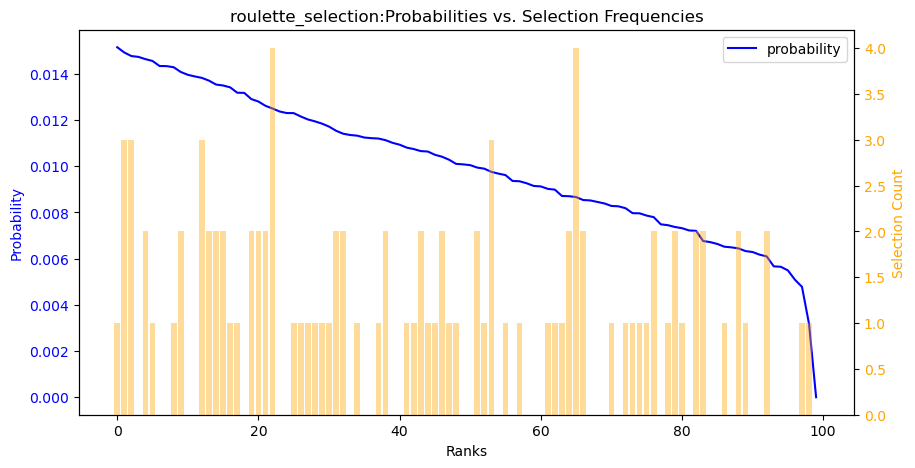

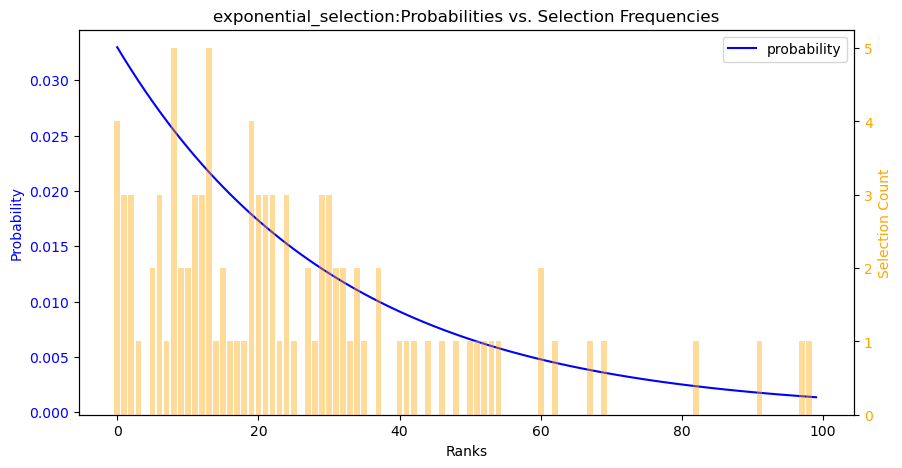

In [185]:
sample = genetic_algorythm(population_size=100, genotyp_size=3, bounds=(-5, 5))
sample.objective_function = simple_func

_ = sample.roulette_selection(population=sample.population, check=True)

_ = sample.exponential_selection(population=sample.population, check=True)

Best solution: 0.026712677698003673 for answer: [ 0.04918052 -0.15581542  0.0027848 ]


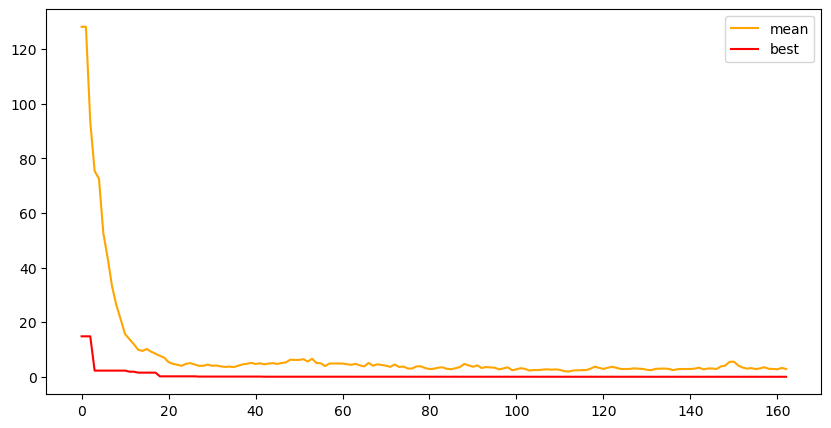

In [199]:
simple_roulette = genetic_algorythm(population_size=50, genotyp_size=3, bounds=(-10, 10))

simple_roulette.learn(objective_function=simple_func, 
             stop_criterion='imporvement', stop_value=50, 
             mutation_prob=0.25, mutation_strength=1, 
             selection_type='roulette', elite_ratio=0.1)

Best solution: 0.017960535285875486 for answer: [-0.00303614  0.094525   -0.06714291]


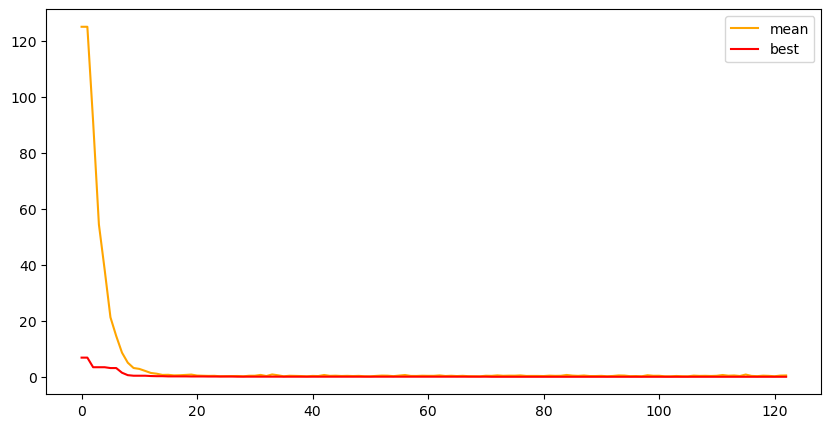

In [198]:
simple_exponential = genetic_algorythm(population_size=50, genotyp_size=3, bounds=(-10, 10))

simple_exponential.learn(objective_function=simple_func, 
             stop_criterion='imporvement', stop_value=50, 
             mutation_prob=0.25, mutation_strength=1, 
             selection_type='exponential', elite_ratio=0.1)

Best solution: 951.3457738435783 for answer: [-0.02150595 -0.02418452 -0.01116044  0.97463623 -0.01366158]


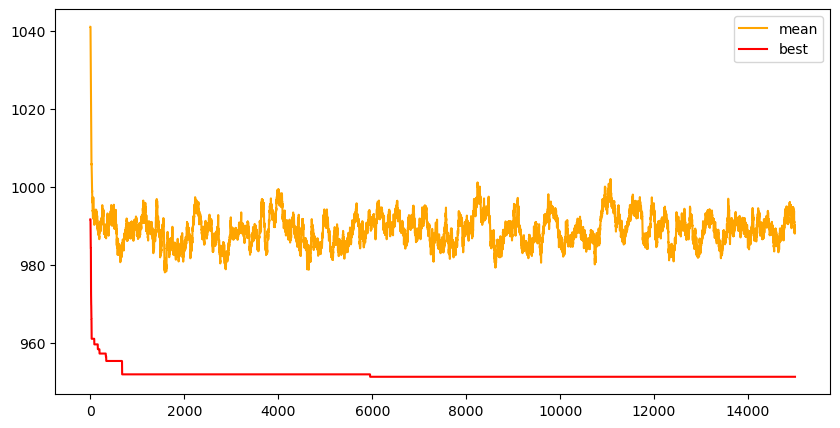

In [376]:
rastring_exponential = genetic_algorythm(population_size=100, genotyp_size=5, bounds=(-5.12, 5.12))

rastring_exponential.learn(objective_function=rastring_func, 
             stop_criterion='iterations', stop_value=15000, 
             mutation_prob=0.05, mutation_strength=1, 
             selection_type='roulette', elite_ratio=0.5)

Best solution: 50.53162464730684 for answer: [-0.02389891  0.01869778  0.03276111  0.02424157  0.01021544]


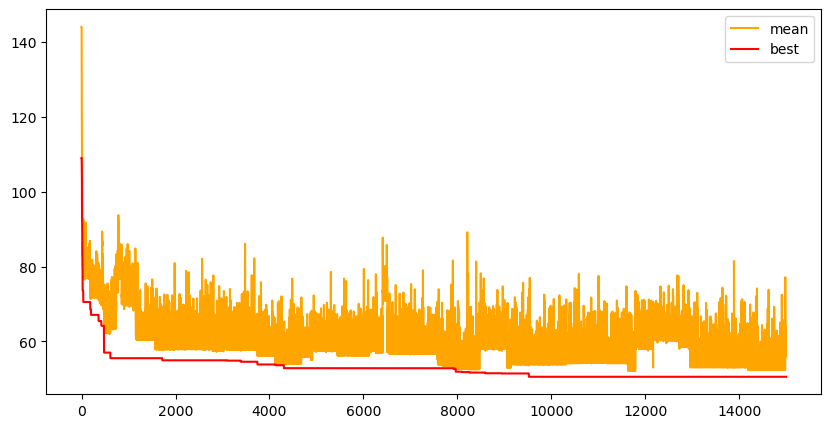

In [371]:
rastring_exponential = genetic_algorythm(population_size=10, genotyp_size=5, bounds=(-5.12, 5.12))

rastring_exponential.learn(objective_function=rastring_func, 
             stop_criterion='iterations', stop_value=15000, 
             mutation_prob=0.25, mutation_strength=1, 
             selection_type='exponential', elite_ratio=0.1)